In [412]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from wordcloud import WordCloud
import nltk
nltk.data.path.append(r"c:\Users\Work\Desktop\projects\project2\project2-movie-env\Lib\site-packages\nltk")
from nltk.corpus import stopwords



#Options

In [413]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Work\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Work\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [414]:
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", lambda x: f"{x :.2f}")
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('french'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

# Connect to the database and create df



In [415]:
con = duckdb.connect('movies.db')

In [416]:
movies = con.table('movies').df()
con.close()

In [417]:
movies.head()

,backdrop_path,id,imdb_id,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,vote_average,vote_count,genres,actors,actors_id,directors,directors_id,video_name,video_key,keywords
0,/qYHM1QaR86eQeKX8qi8kFtqFAGd.jpg,655363,tt9834506,Post Mortem,"Hongrie, 1919. Miraculeusement revenu du front...",18.31,/4X47HT16UXf96cn1pI2hq31tX31.jpg,2020-10-28,115,Released,Immortalisez vos plus grandes peurs.,Post Mortem,6.70,193,"[Horreur, Mystère, Thriller]","[Viktor Klem, Fruzsina Hais, Judit Schell, Ang...","[1739471, 2481242, 125682, 131215, 1499191, 89...",[Péter Bergendy],[930499],[POST MORTEM Bande Annonce VF (2022)],[pv4NBtvy4zw],[]
1,/dhr0q4eiRr8ltqPig32TwhPRdaD.jpg,17,tt0411267,The Dark,En débarquant dans cette contrée isolée du pay...,32.94,/ebzumprgCpfFUZOTJNZ407FA9IH.jpg,2005-09-28,87,Released,,The Dark,5.80,256,"[Horreur, Thriller, Mystère]","[Maria Bello, Sean Bean, Abigail Stone, Richar...","[49, 48, 55, 51, 54, 56]",[John Fawcett],[43],[],[],"[sea, wales, child abuse, shepherd, adolescenc..."
2,/bQ8fRUaitJvi54O2lUT6Ta7FVHK.jpg,25,tt0418763,Jarhead,"Été 1990. Anthony Swofford, fils et petit‐fils...",93.34,/rpPa7dGWnuldRGyLtr4eT2n38jH.jpg,2005-11-04,123,Released,"La guerre, c’est l’enfer. L’attente, c’est pire.",Jarhead : La Fin de l'innocence,6.65,2747,"[Drame, Guerre]","[Jake Gyllenhaal, Jamie Foxx, Peter Sarsgaard,...","[131, 134, 133, 132, 2955, 10964]",[Sam Mendes],[39],[Jarhead: La fin de l'innocence (VF) - Bande A...,"[3wZjh-2PbIM, peoCGkXCCp4]","[california, gulf war, saudi arabia, petrol, m..."
3,/pR12U3MPxq6aeHHd4sQOml72SSH.jpg,98339,tt1867093,The Samaritan,"Foley, un ancien arnaqueur, tente de changer d...",11.83,/5Lvo5OjSZmirakT8B7xxEnn1h1F.jpg,2012-03-02,90,Released,,Le Samaritain,5.40,197,[Thriller],"[Samuel L. Jackson, Luke Kirby, Ruth Negga, To...","[2231, 7002, 17018, 207, 52703, 6575]",[David Weaver],[545229],[],[],"[prison, drug use, revenge, incest, grifter, p..."
4,/8ln5VUVk7gnNGIb2VNgw8nICDVt.jpg,35,tt0462538,The Simpsons Movie,Lorsque Homer pollue gravement le lac de Sprin...,81.37,/9Vz5sgIG10YNka14cv11dO5CfMF.jpg,2007-07-25,88,Released,La plus grande aventure familiale de tous les ...,"Les Simpson, le film",7.01,7711,"[Animation, Comédie, Familial]","[Dan Castellaneta, Julie Kavner, Nancy Cartwri...","[198, 199, 200, 5586, 5587, 6008]",[David Silverman],[197],"[LES SIMPSON - LE FILM (bande-annonce), Interv...","[8arbBxezySc, Ji32yfWuROQ]","[garbage, pollution, quarantine, environmental..."


# Start EDA

In [418]:
movies.describe()



,id,popularity,release_date,runtime,vote_average,vote_count
count,8686.00,8686.00,8686,8686.00,8686.00,8686.00
mean,314065.49,39.49,2014-12-30 23:28:59.903292,105.16,6.53,1503.40
min,17.00,0.60,2004-05-07 00:00:00,0.00,5.00,150.00
25%,47785.75,16.11,2010-10-21 06:00:00,93.00,6.00,245.00
50%,290861.50,24.81,2015-07-23 00:00:00,102.00,6.50,478.00
75%,503914.75,42.47,2019-03-29 00:00:00,114.00,7.06,1351.75
max,1226841.00,1611.66,2024-04-19 00:00:00,247.00,9.10,35633.00
std,272921.40,60.10,NaN,18.25,0.72,2843.69


In [419]:
movies.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8686 entries, 0 to 8685
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   backdrop_path   8681 non-null   object        
 1   id              8686 non-null   int32         
 2   imdb_id         8685 non-null   object        
 3   original_title  8686 non-null   object        
 4   overview        8686 non-null   object        
 5   popularity      8686 non-null   float64       
 6   poster_path     8686 non-null   object        
 7   release_date    8686 non-null   datetime64[us]
 8   runtime         8686 non-null   int32         
 9   status          8686 non-null   object        
 10  tagline         8686 non-null   object        
 11  title           8686 non-null   object        
 12  vote_average    8686 non-null   float64       
 13  vote_count      8686 non-null   int32         
 14  genres          8686 non-null   object        
 15  acto

In [420]:
movies['vote_count'].describe()




count    8686.00
mean     1503.40
std      2843.69
min       150.00
25%       245.00
50%       478.00
75%      1351.75
max     35633.00
Name: vote_count, dtype: float64

In [421]:
movies['vote_average'].describe()



count   8686.00
mean       6.53
std        0.72
min        5.00
25%        6.00
50%        6.50
75%        7.06
max        9.10
Name: vote_average, dtype: float64

In [422]:
c = movies['vote_average'].mean()
c

6.531142067695142

In [423]:
#m= movies['vote_count'].quantile(0.5)
m = 150

In [424]:
def weighted_rating(df: pd.DataFrame,m: int=m, c: float=c)->float:
    v = df['vote_count']
    r = df['vote_average']
    return (v / (v+m)) * r + (m / (v+m)) * c



In [425]:
movies['imbd_score'] = movies.apply(weighted_rating, axis=1)

movies_sort_score = movies.sort_values(by='imbd_score', ascending=False)
movies_sort_score[['title','imbd_score','popularity','vote_count','vote_average']].head(10)




,title,imbd_score,popularity,vote_count,vote_average
1255,Parasite,8.49,96.98,17476,8.51
46,The Dark Knight : Le Chevalier noir,8.49,113.72,31845,8.50
3425,Your Name.,8.47,77.80,10940,8.50
7349,Interstellar,8.42,388.92,34210,8.43
8117,Spider-Man : New Generation,8.39,134.07,14945,8.41
4762,Whiplash,8.38,166.70,14574,8.40
1308,Le Château ambulant,8.38,108.00,9404,8.41
7566,Inception,8.36,382.25,35633,8.37
3548,Spider-Man : Across the Spider-Verse,8.33,240.73,6200,8.37
5329,Silent Voice,8.31,50.63,3766,8.38


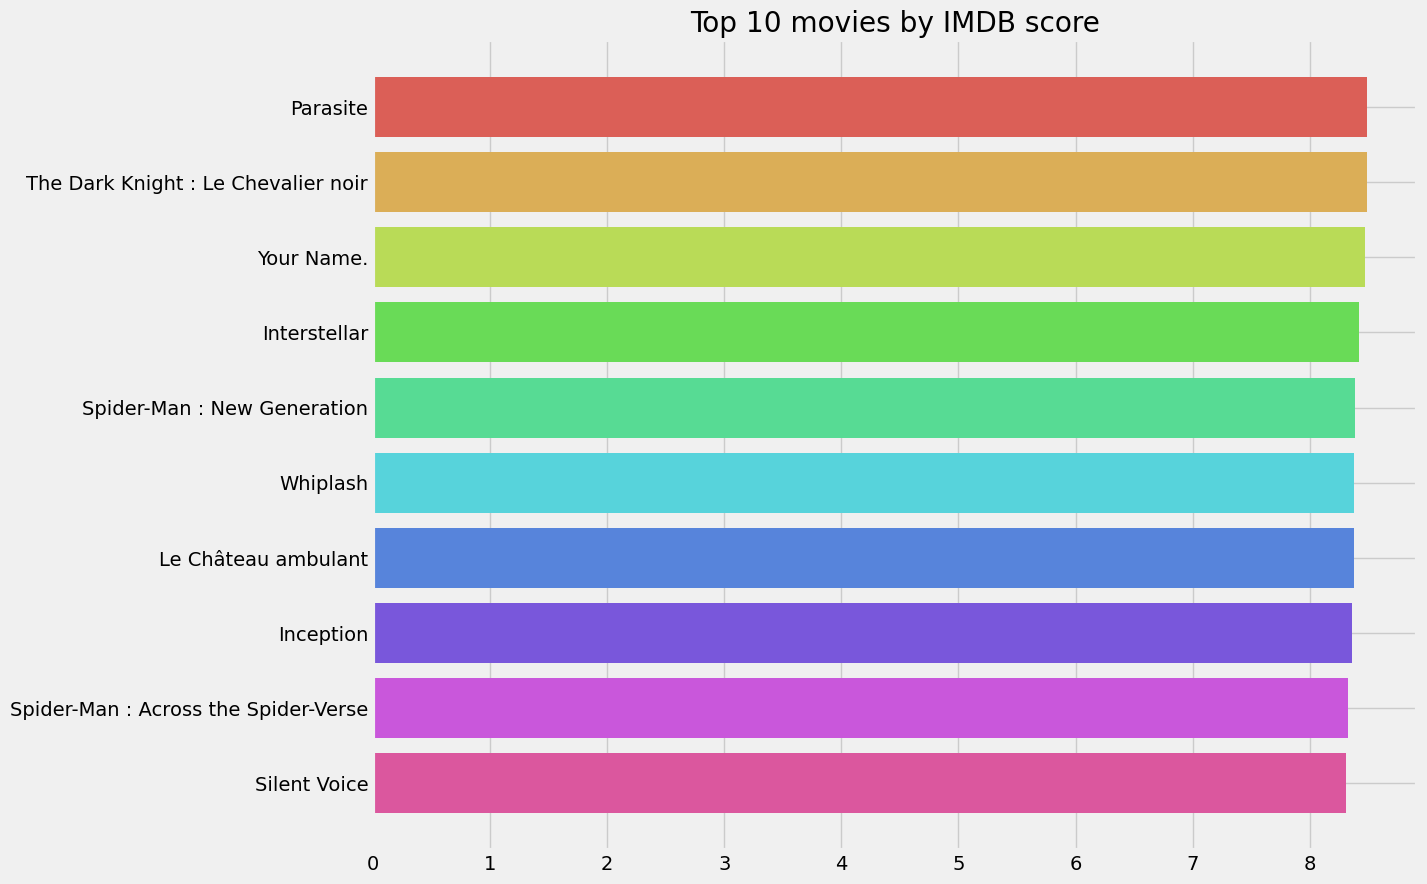

In [426]:
plt.subplots(figsize=(12,10))
plt.barh(movies_sort_score['title'].head(10),movies_sort_score['imbd_score'].head(10),color=sns.color_palette('hls',10))
plt.gca().invert_yaxis()
plt.title('Top 10 movies by IMDB score')
plt.show()



In [427]:
movies['imbd_score'].describe()



count   8686.00
mean       6.55
std        0.56
min        5.07
25%        6.14
50%        6.51
75%        6.92
max        8.49
Name: imbd_score, dtype: float64

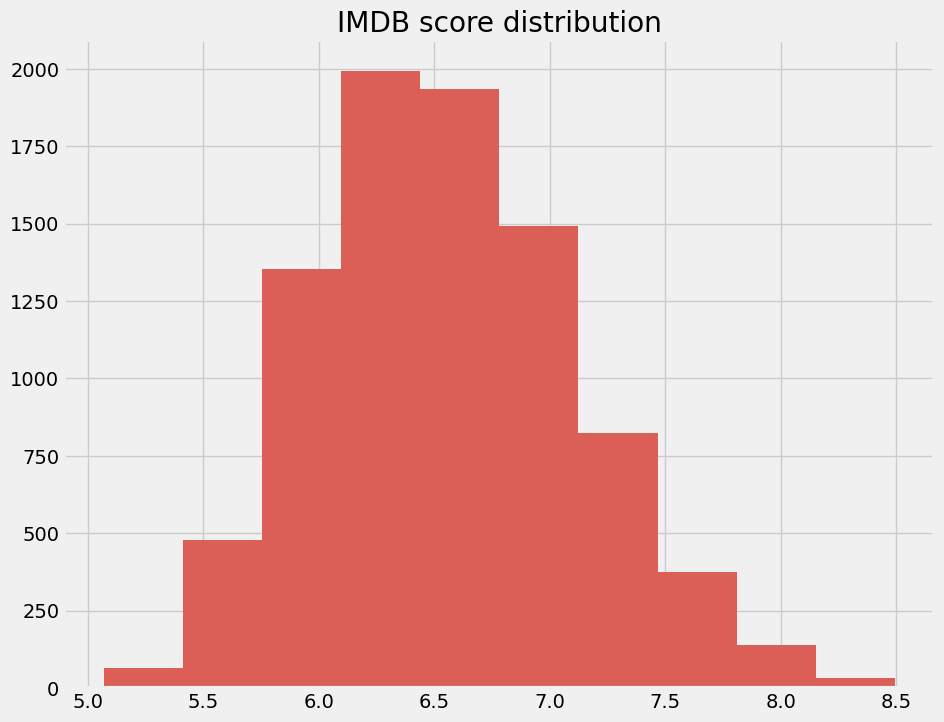

In [428]:
plt.subplots(figsize=(10,8))
plt.hist(movies['imbd_score'],bins=10,color=sns.color_palette('hls',1))
plt.title('IMDB score distribution')
plt.show()




# overview/tagline. trying out TF-IDF


In [429]:
#Define a TF-IDF Vectorizer Object. Remove all french stop words
tfidf = TfidfVectorizer(stop_words=list(stop_words), lowercase=True)



In [430]:
#add tagline to overview
movies['tagline'] = movies['tagline'].fillna('')
movies['description'] = movies['overview'] +' ' + movies['tagline']
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8686, 35148)

In [431]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [432]:
#Construct a reverse map of index and movie titles
index = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [433]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = index[title]
    #idx = movies.index[movies['title'] == title][0]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

In [434]:
movies2 = movies[['title','genres','actors','directors','keywords']]



# Genres columns

In [435]:
movies2['genres'] = movies2['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies2['genres'] = movies2['genres'].str.split(',')



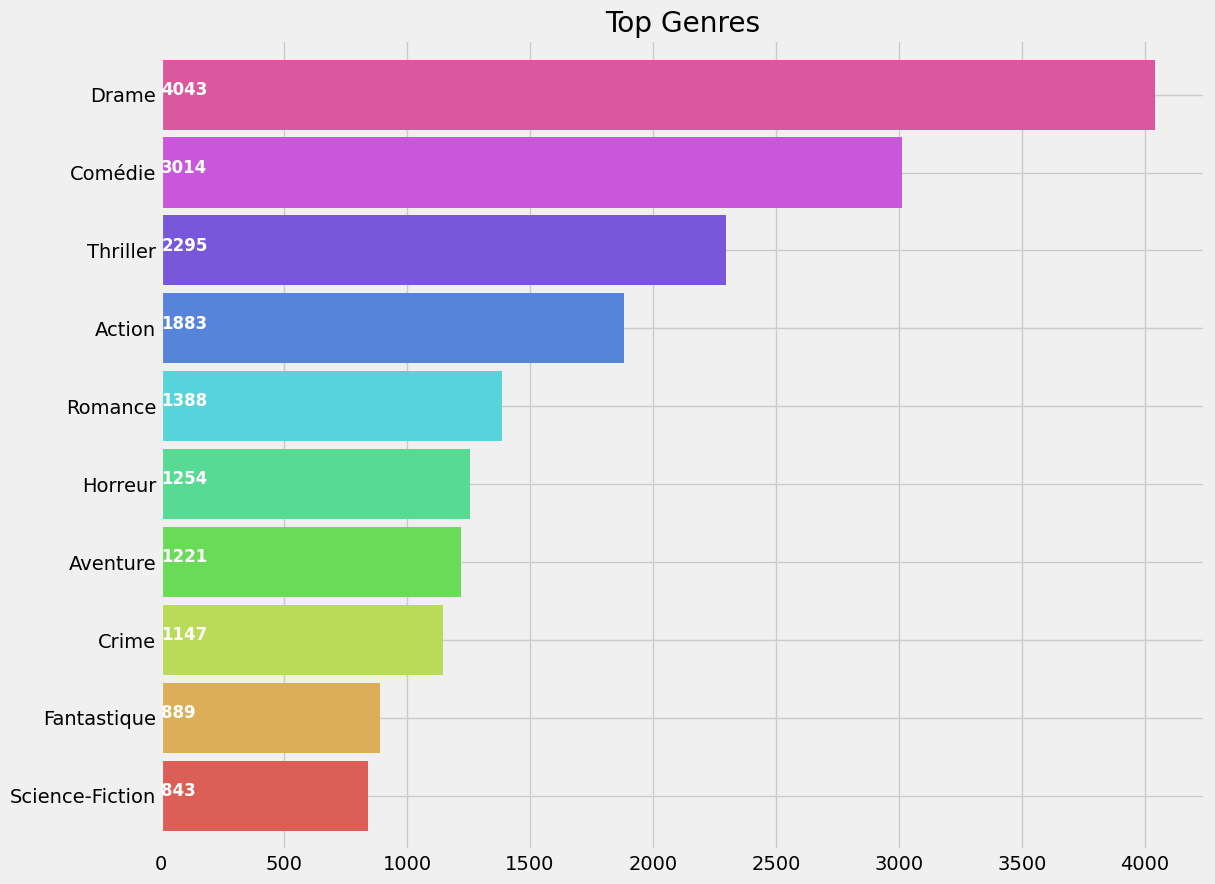

In [436]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies2['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(0.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

# Actors columns

In [437]:
movies2['actors'] = movies2['actors'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies2['actors'] = movies2['actors'].str.split(',')



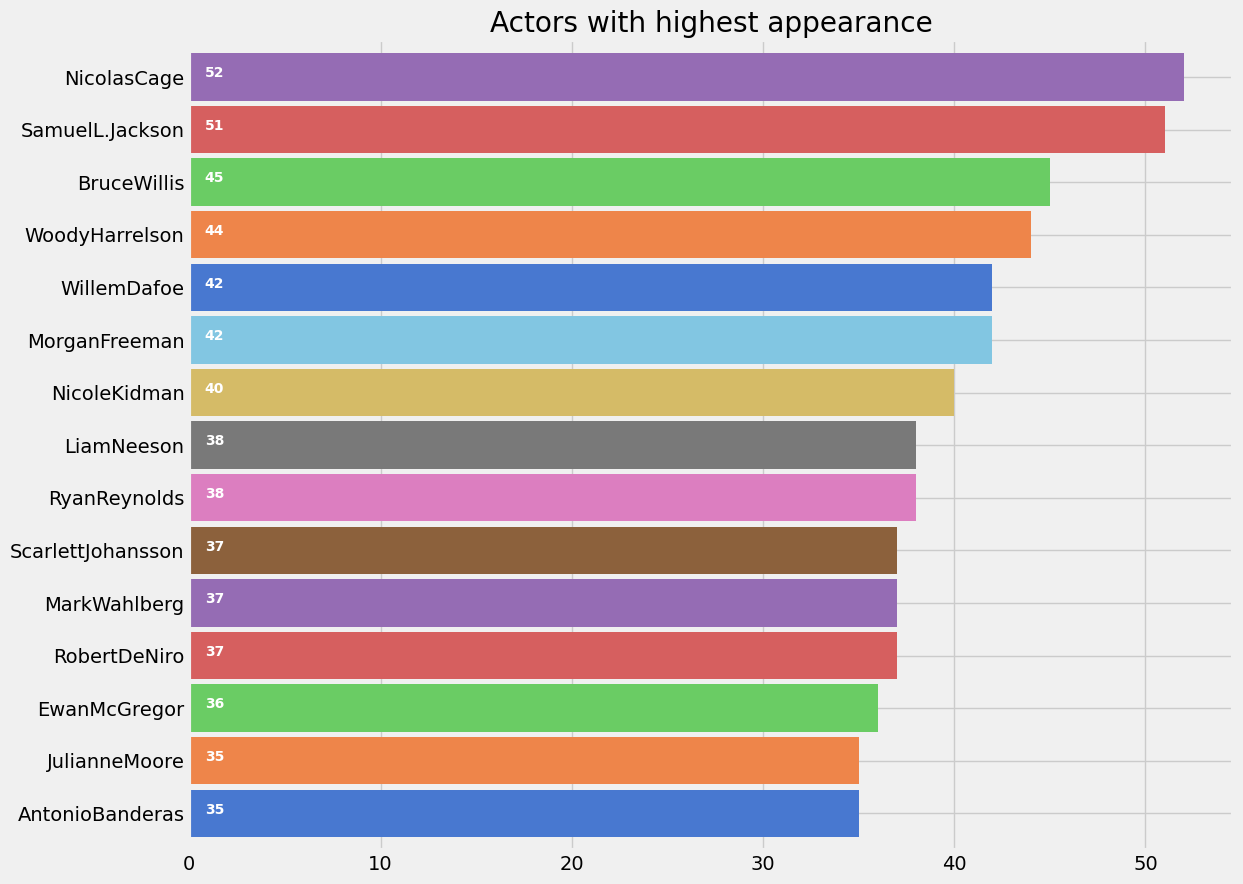

In [438]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies2['actors']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

# directors column

In [439]:
movies2['directors'] = movies2['directors'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies2['directors'] = movies2['directors'].str.split(',')



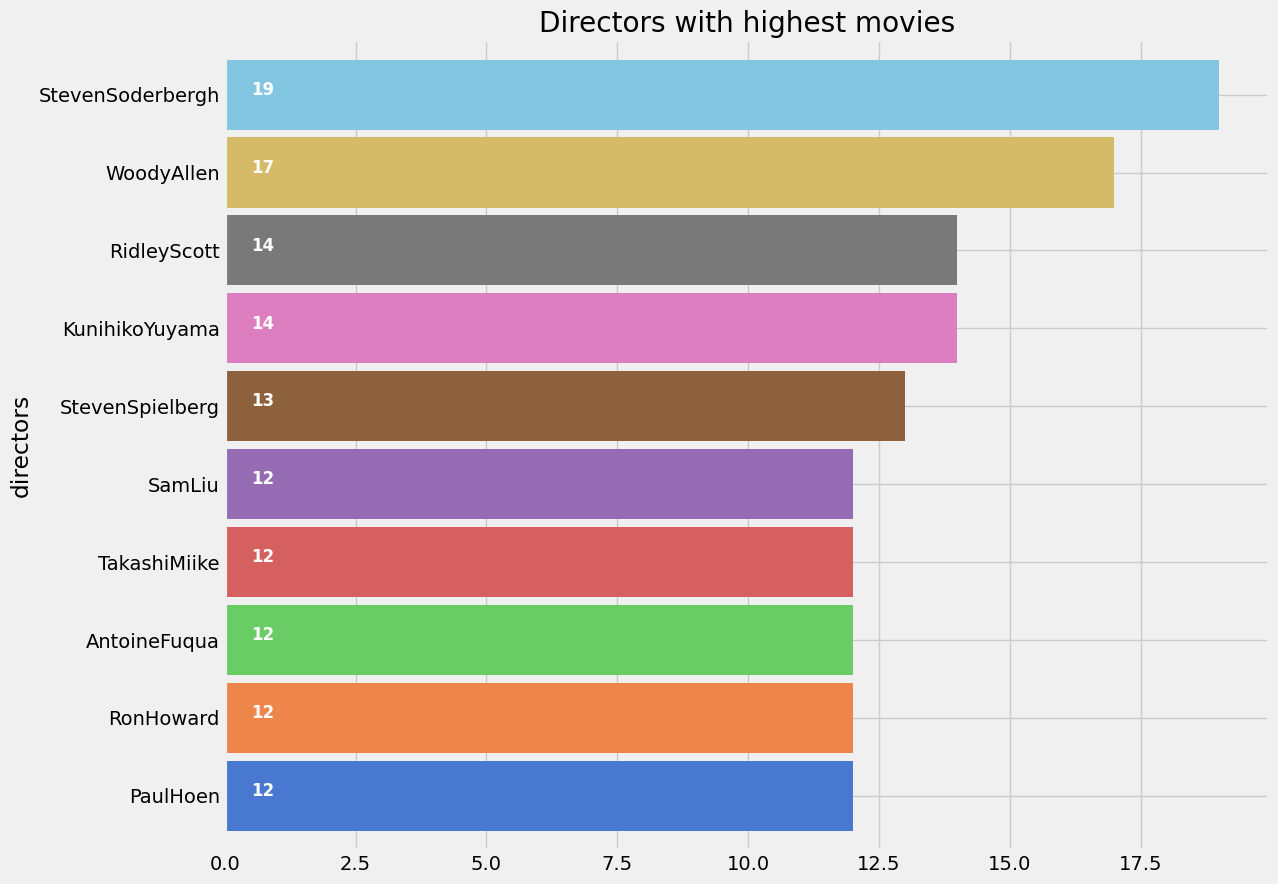

In [440]:
plt.subplots(figsize=(12,10))
filtered_movies = movies2[(movies['directors'] != '') & (~movies2['directors'].apply(lambda x: 'Unknown' in x))]
ax = filtered_movies.explode('directors')['directors'].value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(filtered_movies.explode('directors')['directors'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

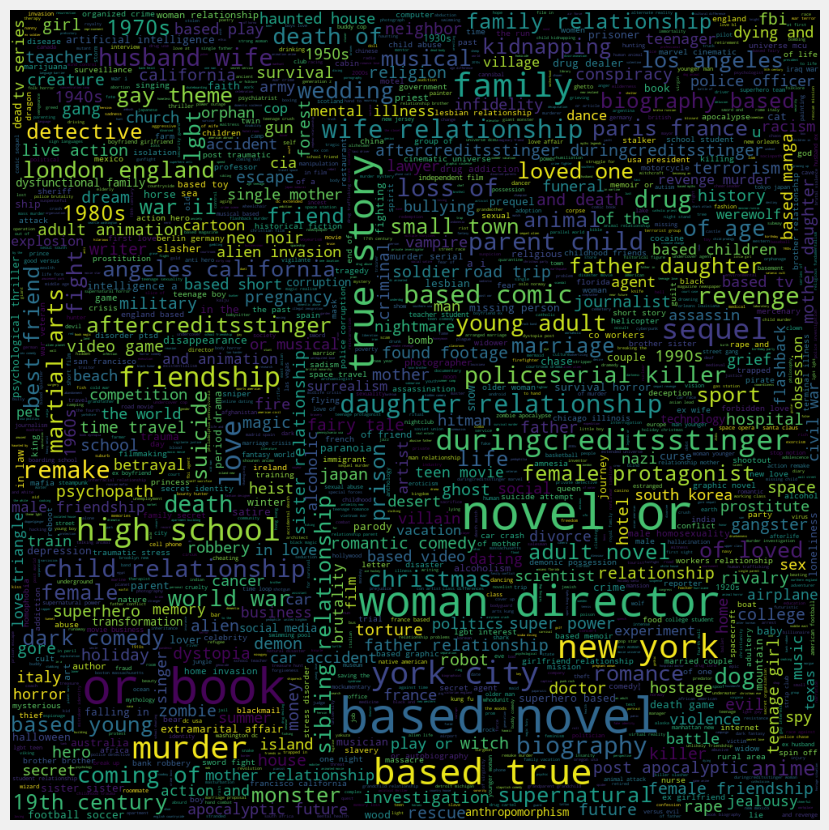

In [441]:
plt.subplots(figsize=(12,12))


words=movies2['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=stop_words, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [442]:
liste_title = movies['title'].tolist()

In [443]:
random_title_choice = np.random.choice(liste_title)
#random_title_choice = 'Babysitting 2'
print(random_title_choice)

Promare


In [444]:
row = movies[movies['title'] == random_title_choice]
print(row.index[0])


7989


In [445]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''




In [446]:
features = ['actors', 'keywords', 'directors', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [447]:
def create_mix(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['actors']) + ' ' + x['directors'] + ' ' + ' '.join(x['genres'])
movies['mixed'] = movies.apply(create_mix, axis=1)

In [448]:
movies['popularity_log'] = np.log1p(movies['popularity'])

In [449]:
count = CountVectorizer(stop_words=list(stop_words))
count_matrix = count.fit_transform(movies['mixed'])



In [450]:
scaler = StandardScaler()
numerical_columns = ['imbd_score', 'popularity_log', 'vote_average']
numerical_features = scaler.fit_transform(movies[numerical_columns])



In [451]:
# Concatenate text and numerical features
combined_features = pd.DataFrame(count_matrix.toarray(), columns=count.get_feature_names_out())
combined_features[numerical_columns] = numerical_features

In [452]:
cosine_sim2 = cosine_similarity(combined_features, combined_features)

In [453]:
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [454]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

302                             Le Prestige
46      The Dark Knight : Le Chevalier noir
7349                           Interstellar
7566                              Inception
93                            Batman Begins
4369                              Dunkerque
6020                            Oppenheimer
4762                               Whiplash
8117            Spider-Man : New Generation
5131                   Inglourious Basterds
Name: title, dtype: object

In [455]:
get_recommendations('The Dark Knight Rises')

4679            Batman : The Long Halloween 1ère Partie
46                  The Dark Knight : Le Chevalier noir
6298                                         The Batman
8112                               Lego Batman, le film
7445                                   Batman vs. Robin
6009    Batman: La Malédiction Qui s'abattit sur Gotham
4680            Batman : The Long Halloween 2ème Partie
93                                        Batman Begins
3210                    La Ligue des Justiciers : Échec
5118                                              Joker
Name: title, dtype: object

In [457]:
movies.to_parquet('streamlit/data/movies.parquet')

